# Dynamic and linearization


In [ ]:
from functools import partial

import jax
import jax.numpy as jnp
from jax import lax, jacrev, jit, vmap

# -----------------------------------------------------------------------------
# configuration ----------------------------------------------------------------
# -----------------------------------------------------------------------------
# Use fp64 for the Riccati recursion – far more stable for horizons > 50.
# (You can toggle back to fp32 later by commenting out the next line.)
jax.config.update("jax_enable_x64", True)

# -----------------------------------------------------------------------------
# interaction maps ----------------------------------------
# -----------------------------------------------------------------------------

def compute_interactions(
    x: jnp.ndarray,
    uL: jnp.ndarray,
    uF: jnp.ndarray,
    alpha: float,
    sigma: float,
    eps: float = 1e-4,
):
    """Pairwise Gaussian affinity and influence equilibrium.

    Args
    ----
    x      : (n, d) agents' positions
    uL/uF  : (d,)  leader / follower attractors
    Returns
    -------
    phi : (n,)   blending weight in [0,1]
    W   : (n,n)  row-stochastic similarity matrix
    b,y : auxiliaries (exposed for debugging only)
    """
    # pairwise Gaussian similarities -----------------------------------
    diff = x[:, None, :] - x[None, :, :]  # (n,n,d)
    W = jnp.exp(-jnp.sum(diff * diff, axis=-1) / (2.0 * sigma**2))
    W = W - jnp.eye(x.shape[0], dtype=x.dtype)
    W = W / jnp.sum(W, axis=1, keepdims=True)  # row normalise


    # leader/follower bias in position space ---------------------------
    b = (
        jnp.exp(-jnp.sum((x - uF) ** 2, axis=1) / (2.0 * sigma**2))
        - jnp.exp(-jnp.sum((x - uL) ** 2, axis=1) / (2.0 * sigma**2))
    )

    # influence equilibrium (I - α W) y = b  ---------------------------
    y = jnp.linalg.solve(jnp.eye(x.shape[0], dtype=x.dtype)*(1+eps) - alpha * W, b)  # JAX has a custom JVP for solve

    phi = jax.nn.sigmoid(y)  # squash to (0,1)
    return phi, W, b, y

# -----------------------------------------------------------------------------
# network dynamics -------------------------------------------------------------
# -----------------------------------------------------------------------------

def dynamics(
    x: jnp.ndarray,
    uL: jnp.ndarray,
    uF: jnp.ndarray,
    eta: float,
    alpha: float,
    sigma: float,
    x0: jnp.ndarray,
    lam: float=0.7,
):
    """Consensus-with-bias forward Euler step."""
    phi, W, b, y = compute_interactions(x, uL, uF, alpha, sigma)
    phi = phi[:, None]
    # return (1 - lam) * x0 + lam*(x +  1* eta * (((1.0 - phi) * (uL) + phi * (uF))-x))
    return (1 - lam) * x0 + lam*(x +  jnp.sqrt(y[:,None]**2 +1e-6) * eta * (((1.0 - phi) * (uL) + phi * (uF))-x))

# -----------------------------------------------------------------------------
# linearization wrt state & controls ------------------------------------------
# -----------------------------------------------------------------------------

def linearise_dynamics(f_dyn, x, uL, uF):
    """A, B_L, B_F via forward-mode Jacobians (no extra jit)."""
    n, d = x.shape
    x_flat = x.reshape(-1)

    def f_flat_state(x_vec):
        return f_dyn(x_vec.reshape((n, d)), uL, uF).reshape(-1)

    A = jacrev(f_flat_state)(x_flat)  # (nd, nd)
    B_L = jacrev(lambda uL_: f_dyn(x, uL_, uF).reshape(-1))(uL)  # (nd, d)
    B_F = jacrev(lambda uF_: f_dyn(x, uL, uF_).reshape(-1))(uF)  # (nd, d)
    return A, B_L, B_F



# Solver

In [ ]:
# -----------------------------------------------------------------------------
# finite-horizon TV-LQR (discrete Riccati) -------------------------------------
# -----------------------------------------------------------------------------

def solve_tvlqr(
    A_seq: jnp.ndarray,
    B_seq: jnp.ndarray,
    Q_xx: jnp.ndarray,
    R_uu: jnp.ndarray,
    Q_xu: jnp.ndarray,
    q_seq: jnp.ndarray,
    r_seq: jnp.ndarray,
    P_T: jnp.ndarray,
    p_T: jnp.ndarray,
):
    """Backward Riccati sweep with small LM regularisation."""
    T = A_seq.shape[0]
    nd = Q_xx.shape[0]
    d = R_uu.shape[0]

    K_seq = jnp.zeros((T, d, nd), dtype=A_seq.dtype)
    kff_seq = jnp.zeros((T, d), dtype=A_seq.dtype)

    lm_eps = 1e-6 * jnp.eye(d, dtype=A_seq.dtype)  # Levenberg-Marquardt term

    def body(i, carry):
        Pn, pn, Ks, kffs = carry
        t = T - 1 - i
        A = A_seq[t]
        B = B_seq[t]

        S_xx = Q_xx + A.T @ Pn @ A
        S_xu = Q_xu + A.T @ Pn @ B
        S_uu = R_uu + B.T @ Pn @ B + lm_eps
        S_x = q_seq[t] + A.T @ pn
        S_u = r_seq[t] + B.T @ pn

        # feedback & feed-forward gains
        K_t = -jnp.linalg.solve(S_uu, S_xu.T)       # (d, nd)
        k_t = -jnp.linalg.solve(S_uu, S_u)          # (d,)

        # value recursion (note the *minus* sign compared to raw textbook)
        P_t = S_xx - S_xu @ jnp.linalg.solve(S_uu, S_xu.T)
        p_t = S_x - S_xu @ jnp.linalg.solve(S_uu, S_u)

        Ks = Ks.at[t].set(K_t)
        kffs = kffs.at[t].set(k_t)
        return P_t, p_t, Ks, kffs

    _, _, K_seq, kff_seq = lax.fori_loop(0, T, body, (P_T, p_T, K_seq, kff_seq))
    return K_seq, kff_seq


# -----------------------------------------------------------------------------
# forward rollout with simultaneous Δu (scan) ----------------------------------
# -----------------------------------------------------------------------------

def forward_pass_scan(
    x0: jnp.ndarray,
    x_nom: jnp.ndarray,
    uL_nom: jnp.ndarray,
    uF_nom: jnp.ndarray,
    K_L_seq: jnp.ndarray,
    kff_L_seq: jnp.ndarray,
    K_F_seq: jnp.ndarray,
    kff_F_seq: jnp.ndarray,
    f_dyn,
    gamma: float,
):
    """One forward rollout with state-deviation feedback + scale γ."""

    def step(x_prev, inputs):
        x_nom_t, uL_nom_t, uF_nom_t, KL_t, kL_t, KF_t, kF_t = inputs
        dx_flat = (x_prev - x_nom_t).reshape(-1)
        uL_t = uL_nom_t + gamma * kL_t + KL_t @ dx_flat
        uF_t = uF_nom_t + gamma * kF_t + KF_t @ dx_flat
        x_next = f_dyn(x_prev, uL_t, uF_t)
        return x_next, (x_next, uL_t, uF_t)

    scan_inputs = (x_nom[:-1], uL_nom, uF_nom,
                    K_L_seq, kff_L_seq, K_F_seq, kff_F_seq,)

    _, (x_hist, uL_hist, uF_hist) = lax.scan(step, x0, scan_inputs)
    x_prop = jnp.concatenate([x0[None], x_hist], axis=0)
    return x_prop, uL_hist, uF_hist

# -----------------------------------------------------------------------------
# main solver ------------------------------------------------------------------
# -----------------------------------------------------------------------------

@partial(
    jit,
    static_argnames=(
        "tom_level_leader",
        "tom_level_follower",
        "num_iters",
    ),
)
def solve_ilqr_tom_jit(
    x0: jnp.ndarray,
    uL_init: jnp.ndarray,
    uF_init: jnp.ndarray,
    Qxx_L: jnp.ndarray,
    Ruu_L: jnp.ndarray,
    Qxx_F: jnp.ndarray,
    Ruu_F: jnp.ndarray,
    qL: jnp.ndarray,
    qF: jnp.ndarray,
    eta: float,
    alpha: float,
    sigma: float,
    tom_level_leader: int,
    tom_level_follower: int,
    lam: float =0.7,
    num_iters: int = 10,
):
    """iLQR + independent level-k ToM – **without** any line search.

    Each outer iLQR iteration linearises around the current trajectory,
    solves the Riccati recursions (possibly nested for ToM levels),
    and applies the full (γ = 1) feedback step once.
    """

    T, d = uL_init.shape
    n_agents, d_agent = x0.shape
    nd = n_agents * d_agent

    f_dyn = lambda xs, uL, uF: dynamics(xs, uL, uF, eta, alpha, sigma,x0,lam)

    # holders -----------------------------------------------------------
    K_L_seq = jnp.zeros((T, d, nd), dtype=x0.dtype)
    kff_L = jnp.zeros((T, d), dtype=x0.dtype)
    K_F_seq = jnp.zeros((T, d, nd), dtype=x0.dtype)
    kff_F = jnp.zeros((T, d), dtype=x0.dtype)

    uL_seq = uL_init
    uF_seq = uF_init

    # initial rollout ---------------------------------------------------
    def init_rollout_step(x_prev, ctrl_inputs):
        uL_t, uF_t = ctrl_inputs
        x_next = f_dyn(x_prev, uL_t, uF_t)
        return x_next, x_next

    _, x_hist_init = lax.scan(init_rollout_step, x0, (uL_seq, uF_seq))
    x_seq = jnp.concatenate([x0[None], x_hist_init], axis=0)

    lin_dyn_vmap = vmap(lambda x_t, uL_t, uF_t: linearise_dynamics(f_dyn, x_t, uL_t, uF_t))

    def ilqr_body(i, main_state_carry):
        ( x_seq_curr, uL_seq_curr, uF_seq_curr,
         K_L_seq_curr, kff_L_curr, K_F_seq_curr, kff_F_curr,) = main_state_carry

        x_nom, uL_nom, uF_nom = x_seq_curr, uL_seq_curr, uF_seq_curr

        # linearise dynamics around current nominal trajectory ---------
        A_all_seq, B_L_all_seq, B_F_all_seq = lin_dyn_vmap(x_nom[:-1], uL_nom, uF_nom)

        max_tom = max(tom_level_leader, tom_level_follower)
        K_L_levels = [jnp.zeros_like(K_L_seq_curr) for _ in range(max_tom + 1)]
        kff_L_levels = [jnp.zeros_like(kff_L_curr) for _ in range(max_tom + 1)]
        K_F_levels = [jnp.zeros_like(K_F_seq_curr) for _ in range(max_tom + 1)]
        kff_F_levels = [jnp.zeros_like(kff_F_curr) for _ in range(max_tom + 1)]

        qL_T_seq = jnp.tile(qL, (T, 1))
        qF_T_seq = jnp.tile(qF, (T, 1))
        r_zero_seq = jnp.zeros((T, d), dtype=x0.dtype)
        Q_xu_zero = jnp.zeros((nd, d), dtype=x0.dtype)

        # level-0 policies ------------------------------------------------
        K_L_L0, kff_L_L0 = solve_tvlqr( A_all_seq, B_L_all_seq,
                                        Qxx_L, Ruu_L,Q_xu_zero, qL_T_seq, r_zero_seq, Qxx_L, qL,)
        K_F_L0, kff_F_L0 = solve_tvlqr( A_all_seq, B_F_all_seq,
                                       Qxx_F, Ruu_F, Q_xu_zero, qF_T_seq, r_zero_seq, Qxx_F, qF,)

        K_L_levels[0], kff_L_levels[0] = K_L_L0, kff_L_L0
        K_F_levels[0], kff_F_levels[0] = K_F_L0, kff_F_L0

        # recursive higher levels ---------------------------------------
        for k_iter in range(1, max_tom + 1):
            # follower best-responds to assumed leader policy -------------
            leader_lvl_assumed_by_follower = min(k_iter - 1, tom_level_leader)
            K_L_assumed = K_L_levels[leader_lvl_assumed_by_follower]

            if k_iter <= tom_level_follower:
                A_cl_for_F = A_all_seq + vmap(lambda BL, KL: BL @ KL)(B_L_all_seq,
                                                                      K_L_assumed)

                K_F_levels[k_iter], kff_F_levels[k_iter] = solve_tvlqr(A_cl_for_F, B_F_all_seq,
                                                          Qxx_F, Ruu_F, Q_xu_zero, qF_T_seq, r_zero_seq, Qxx_F, qF,)
            else:
                K_F_levels[k_iter], kff_F_levels[k_iter] = ( K_F_levels[tom_level_follower],
                    kff_F_levels[tom_level_follower],)

            # leader best-responds to assumed follower policy -------------
            follower_lvl_assumed_by_leader = min(k_iter - 1, tom_level_follower)
            K_F_assumed = K_F_levels[follower_lvl_assumed_by_leader]

            if k_iter <= tom_level_leader:
                A_cl_for_L = A_all_seq + vmap(lambda BF, KF: BF @ KF)(B_F_all_seq, K_F_assumed)
                K_L_levels[k_iter], kff_L_levels[k_iter] = solve_tvlqr( A_cl_for_L, B_L_all_seq,
                                                              Qxx_L, Ruu_L, Q_xu_zero, qL_T_seq, r_zero_seq, Qxx_L, qL, )
            else:
                K_L_levels[k_iter], kff_L_levels[k_iter] = (K_L_levels[tom_level_leader],
                                                            kff_L_levels[tom_level_leader],)

        # pick the levels requested for each agent ----------------------
        K_L_seq_new = K_L_levels[tom_level_leader]
        kff_L_new = kff_L_levels[tom_level_leader]
        K_F_seq_new = K_F_levels[tom_level_follower]
        kff_F_new = kff_F_levels[tom_level_follower]

        x_seq_updated, uL_seq_updated, uF_seq_updated = forward_pass_scan( x0, x_nom, uL_nom,uF_nom,
                                                            K_L_seq_new, kff_L_new, K_F_seq_new, kff_F_new, f_dyn, gamma=1.0,)

        return ( x_seq_updated, uL_seq_updated, uF_seq_updated,
                    K_L_seq_new, kff_L_new, K_F_seq_new, kff_F_new,)

    initial_state = (x_seq, uL_seq, uF_seq,
                  K_L_seq, kff_L, K_F_seq, kff_F,)

    final_state = lax.fori_loop(0, num_iters, ilqr_body, initial_state)
    return final_state


# Cluster

In [ ]:
# Receding‑horizon MPC with adaptive clustering for very large crowds.


from __future__ import annotations
from typing import Tuple
from itertools import combinations

import numpy as np
import jax
import jax.numpy as jnp
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import skew, kurtosis  # only used in helpers

# =====================================================================
#  clustering helpers  – now tolerant of tiny clusters
# =====================================================================

def compute_stats(points: np.ndarray):
    """Return (mean, covariance, bimodality‑coef) for an array of shape (n, d).

    Robustified so that *n = 1* (or *0*) no longer crashes downstream linear
    algebra – the covariance is replaced by a zero matrix and BC is 0.0.
    """
    if points.ndim != 2:
        points = points.reshape(-1, points.size)  # fallback – shouldn’t happen

    n, d = points.shape
    if n == 0:
        mu = np.zeros(d)
        cov = np.zeros((d, d))
        bc = 0.0
        return mu, cov, bc

    mu = points.mean(axis=0)

    if n == 1:  # degenerate: no variance information
        cov = np.zeros((d, d))
        bc = 0.0
        return mu, cov, bc

    cov = np.cov(points, rowvar=False)

    # principal‑component projection for bimodality test
    eigvals, eigvecs = np.linalg.eigh(cov)
    pc1 = eigvecs[:, eigvals.argmax()]
    proj = points @ pc1

    sk = skew(proj, bias=False)
    kr = kurtosis(proj, fisher=False, bias=False)
    bc = (sk ** 2 + 1) / kr if kr != 0 else np.inf
    return mu, cov, bc


def compute_marginal_var(cov: np.ndarray, v: np.ndarray) -> float:
    if np.allclose(v, 0):
        return 0.0
    if cov.ndim == 0:  # safeguard for tiny clusters
        return 0.0
    v = v / np.linalg.norm(v)
    return float(v.T @ cov @ v)


def split_clusters(
    x: np.ndarray,
    labels: np.ndarray,
    stats: dict[int, Tuple[np.ndarray, np.ndarray, float]],
    bc_thr: float = 0.55,
    size_thr: int = 50,
) -> Tuple[np.ndarray, dict]:
    labels = labels.copy().astype(int).ravel()
    next_id = labels.max() + 1

    for cid in np.unique(labels):
        idx = np.where(labels == cid)[0]
        pts = x[idx]
        _, _, bc = stats[cid]

        if bc > bc_thr and len(pts) >= size_thr:
            sub = AgglomerativeClustering(n_clusters=2, linkage="ward").fit_predict(pts)
            labels[idx[sub == 1]] = next_id
            stats[next_id] = compute_stats(pts[sub == 1])
            stats[cid] = compute_stats(pts[sub == 0])
            next_id += 1
    return labels, stats


def merge_clusters(
    x: np.ndarray,
    labels: np.ndarray,
    stats: dict[int, Tuple[np.ndarray, np.ndarray, float]],
) -> Tuple[np.ndarray, dict]:
    labels = labels.copy().astype(int).ravel()
    merged = True

    while merged:
        merged = False
        unique = np.unique(labels)

        for ii, jj in combinations(unique, 2):
            muii, covii, _ = stats[ii]
            mujj, covjj, _ = stats[jj]

            v = mujj - muii
            dist = np.linalg.norm(v)
            if dist == 0:
                labels[labels == jj] = ii
                stats.pop(jj, None)
                stats[ii] = compute_stats(x[labels == ii])
                merged = True
                break

            stdii = np.sqrt(compute_marginal_var(covii, v))
            stdjj = np.sqrt(compute_marginal_var(covjj, v))
            if dist < min(stdii, stdjj):
                labels[labels == jj] = ii
                stats.pop(jj, None)
                stats[ii] = compute_stats(x[labels == ii])
                merged = True
                break

    new_ids = {old: i for i, old in enumerate(np.unique(labels))}
    return np.vectorize(new_ids.get)(labels), stats


def cluster_step(
    x: np.ndarray,
    prev_labels: np.ndarray | None = None,
) -> Tuple[np.ndarray, dict]:
    if prev_labels is None:
        n_init = max(2, int(np.sqrt(len(x))))
        # labels = AgglomerativeClustering(n_clusters=n_init, linkage="ward").fit_predict(x)
        labels = AgglomerativeClustering(n_clusters=None,distance_threshold=2, linkage="ward").fit_predict(x)
    else:
        labels = prev_labels

    stats = {cid: compute_stats(x[labels == cid]) for cid in np.unique(labels)}
    labels, stats = split_clusters(x, labels, stats)
    labels, stats = merge_clusters(x, labels, stats)
    return labels, stats



# MPC

In [ ]:

# =====================================================================
#  bring in the dynamics + iLQR‑ToM solver from your existing module
# =====================================================================
# ---------------------------------------------------------------------
#  Cost builders  – depends on *current* cluster set
# ---------------------------------------------------------------------



def build_cost_matrices(
    centres: jnp.ndarray,
    x_init: np.ndarray,
    labels: np.ndarray,
):
    """Return Qxx_L, Ruu_L, Qxx_F, Ruu_F, qL_flat, qF_flat."""
    K, d = centres.shape
    nd = K * d

    Qxx_L = jnp.diag(jnp.tile(jnp.array([3.0, 0.0]), K)) #for syn
    # Qxx_L = jnp.diag(jnp.tile(jnp.array([3.0, 3.0]), K)) #for facebook
    Qxx_F = jnp.eye(nd)
    Ruu_L = 20.0 * jnp.eye(d)
    Ruu_F = 80.0 * jnp.eye(d)

    x_ref_F = np.zeros_like(centres)
    for k in range(K):
        idx = np.where(labels == k)[0]
        x_ref_F[k] = x_init[idx].mean(axis=0)  # mean ORIGINAL location

    qF_flat = -Qxx_F @ jnp.asarray(x_ref_F).reshape(-1)
    x_ref_L_flat = jnp.tile(jnp.array([-1, 0]), K) # for syn
    # x_ref_L_flat = jnp.tile(jnp.array([0, -1.5]), K) # for facebook
    qL_flat = -Qxx_L @ x_ref_L_flat
    return Qxx_L, Ruu_L, Qxx_F, Ruu_F, qL_flat, qF_flat




# ---------------------------------------------------------------------
#  MPC on cluster centroids  (helper)
# ---------------------------------------------------------------------

def run_mpc_on_centres(
    centres: jnp.ndarray,
    H: int,
    eta: float,
    alpha: float,
    sigma: float,
    lam: float,
    Q_L: jnp.ndarray,
    R_L: jnp.ndarray,
    Q_F: jnp.ndarray,
    R_F: jnp.ndarray,
    qL_flat: jnp.ndarray,
    qF_flat: jnp.ndarray,
    tom_L: int,
    tom_F: int,
    num_ilqr_iters: int,
    uL_guess: jnp.ndarray,
    uF_guess: jnp.ndarray,
):
    """Solve level‑k ToM MPC for the meta‑crowd of size K."""
    d = centres.shape[1]

    Xc, uL_plan, uF_plan, *_ = solve_ilqr_tom_jit( centres, uL_guess, uF_guess,
                                            Q_L, R_L, Q_F, R_F, qL_flat, qF_flat,
                                            eta, alpha, sigma,
                                            tom_level_leader=tom_L, tom_level_follower=tom_F,
                                            lam=lam, num_iters=num_ilqr_iters,)
    return Xc, uL_plan, uF_plan

# ---------------------------------------------------------------------
#  MAIN outer loop  – cluster → MPC on centroids → propagate full system
# ---------------------------------------------------------------------

def run_clustered_mpc(
    x_init: np.ndarray,
    T_total: int = 100,
    H: int = 20,
    h_step: int = 5,
    eta: float = 0.5,
    alpha: float = 1 / np.e,
    sigma: float = 1.0,
    lam: float = 0.9,
    tom_L: int = 9,
    tom_F: int = 10,
    num_ilqr_iters: int = 1,
):
    """Outer loop that acts on the original *N*-agent crowd."""

    N, d = x_init.shape
    x_init_jnp = jnp.asarray(x_init)  # fixed reference for dynamics contractive term

    X_hist = jnp.zeros((T_total + 1, N, d))
    X_hist = X_hist.at[0].set(x_init_jnp)
    uL_log = jnp.zeros((T_total, d))
    uF_log = jnp.zeros((T_total, d))
    uL_init = -1*jnp.ones((H, d)) # for syn
    uF_init = jnp.zeros((H, d))   # for syn
    # uL_init = jnp.zeros((H, d))     # for facebook
    # uF_init = -1*jnp.ones((H, d))   # for facebook



    labels = None  # no prior clustering the first time
    x_curr = x_init_jnp
    t = 0
    while t < T_total:
        # ---------- 1) cluster current agent positions ---------------
        labels, stats = cluster_step(np.array(x_curr))
        centres_np = np.asarray([stats[k][0] for k in range(len(stats))])
        centres = jnp.asarray(centres_np)
        print("# clusters:",centres_np.shape[0])
        # uL_init = jnp.zeros((H, d))
        # uF_init = jnp.zeros((H, d))
        # ---------- 2) build cost matrices for the meta‑system -------
        Q_L, R_L, Q_F, R_F, qL_flat, qF_flat = build_cost_matrices(
            centres, x_init, labels
        )

        # ---------- 3) solve MPC on centroids ------------------------
        _, uL_plan, uF_plan = run_mpc_on_centres(
            centres,
            H=H,
            eta=eta,
            alpha=alpha,
            sigma=sigma,
            lam=lam,
            Q_L=Q_L,
            R_L=R_L,
            Q_F=Q_F,
            R_F=R_F,
            qL_flat=qL_flat,
            qF_flat=qF_flat,
            tom_L=tom_L,
            tom_F=tom_F,
            num_ilqr_iters=num_ilqr_iters,
            uL_guess=uL_init,
            uF_guess=uF_init,
        )

        # how many steps can we still advance?
        n_apply = min(h_step, T_total - t)

        # ---------- 4) propagate the *full* agent system -------------
        for k in range(n_apply):
            uL_apply = uL_plan[k]
            uF_apply = uF_plan[k]

            x_next = dynamics(
                x_curr,
                uL_apply,
                uF_apply,
                eta,
                alpha,
                sigma,
                x0=x_init_jnp,  # contractive term w.r.t original locations
                lam=lam,
            )
            uL_log = uL_log.at[t + k].set(uL_apply)
            uF_log = uF_log.at[t + k].set(uF_apply)
            X_hist = X_hist.at[t + k + 1].set(x_next)
            x_curr = x_next
        t += n_apply
        uL_init = uL_plan[-1:].repeat(H, axis=0)
        uF_init = uF_plan[-1:].repeat(H, axis=0)

    return X_hist, uL_log, uF_log

# Synthetic

# clusters: 59
# clusters: 54
# clusters: 53
# clusters: 52
# clusters: 52
# clusters: 52
# clusters: 51
# clusters: 54
# clusters: 56
# clusters: 56


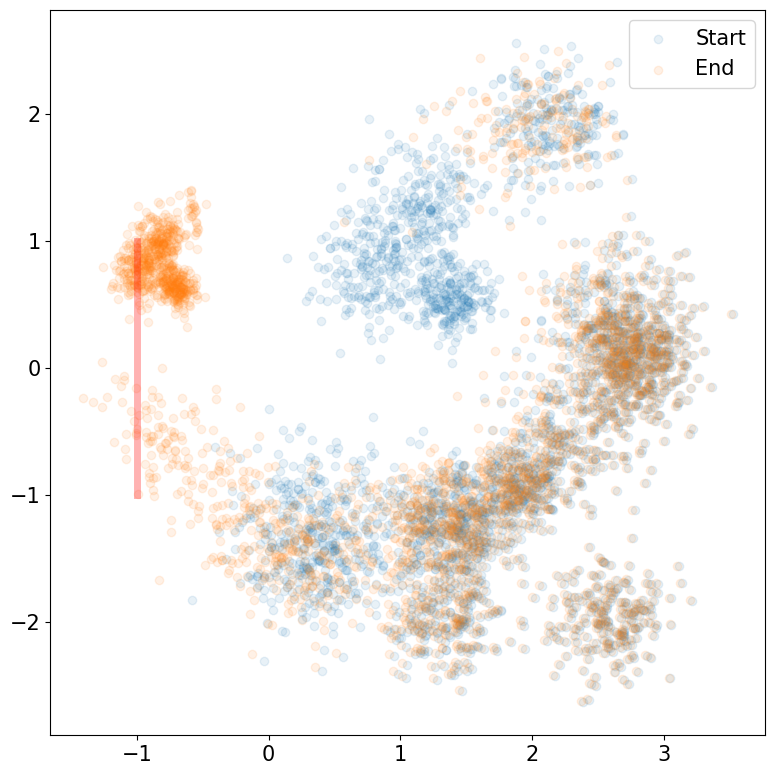

In [ ]:
# =====================================================================
#  Results
# =====================================================================
import numpy as np
import matplotlib.pyplot as plt

# Synthetic Network
Synthetic=1
if Synthetic:
    rng = np.random.default_rng(0)
    K0, N_per, d = 15, 200, 2
    N = K0 * N_per
    xs = np.empty((N, d))
    for k in range(K0):
        mean = np.array([
            rng.uniform(0, 3),  # positive x‑coordinate for centre
            rng.uniform(-2, 2),
        ])
        # A = rng.normal(size=(d, d))
        A=np.eye(d)
        cov = (A @ A.T) * rng.uniform(0.02, .1)  # random SPD
        xs[k * N_per : (k + 1) * N_per] = rng.multivariate_normal(mean, cov, N_per)

    T_total=100
    X_hist, uL, uF = run_clustered_mpc(
        xs,
        T_total=T_total,
        H=60,
        h_step=10,
        eta=.5 ,
        alpha=.3,
        sigma=1,
        lam=0.7,
        tom_L=9,
        tom_F=10,
        num_ilqr_iters=1,
    )


X=np.array(X_hist)
plt.figure(figsize=(8, 8))
plt.scatter(X[0, :, 0],X[0,:,1],alpha=0.1,label='Start')
plt.scatter(X[-1, :, 0],X[-1,:,1],alpha=0.1,label='End')
plt.plot([-1,-1],[-1,1],c='r',alpha=0.3,linewidth=5)

plt.legend()
plt.tight_layout()
plt.show()

## Final Plots

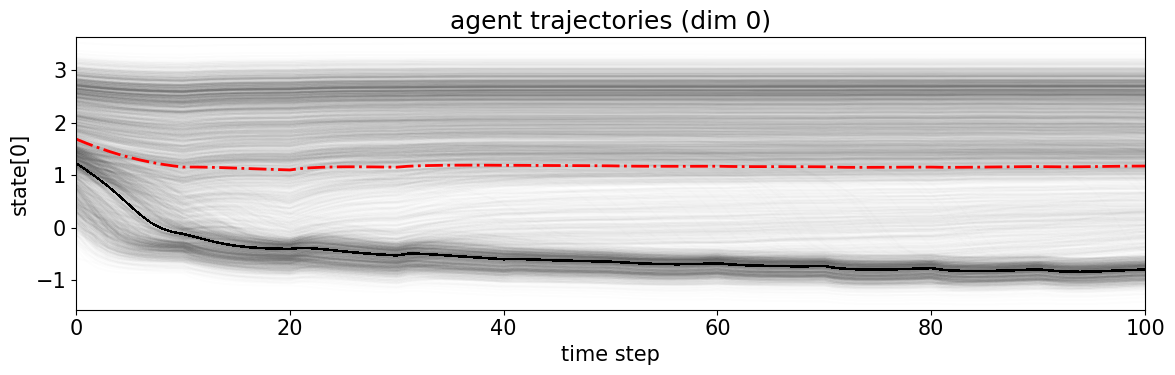

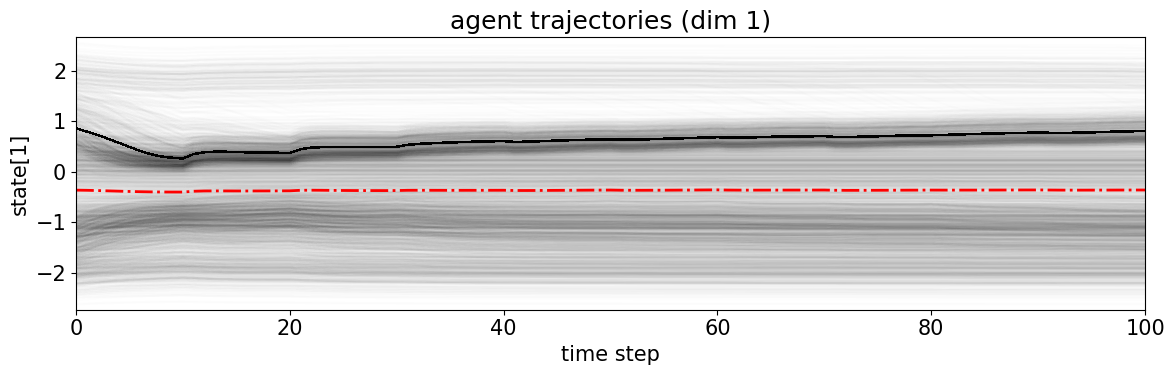

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import jax.numpy as jnp

plt.rcParams.update({'font.size': 15})

# initial “second” state (dim=1) for each agent
init_vals = X_hist[0, :, 1]  # shape (n_agents,)

for dim_idx in range(d_agent):
    # create fig/ax so we can pass ax to colorbar
    fig, ax = plt.subplots(figsize=(12, 4))

    # plot each agent trajectory
    for agent_idx in range(n_agents):
        color = cmap(norm(init_vals[agent_idx]))
        ax.plot(time_steps,
                X_hist[:, agent_idx, dim_idx],
                alpha=0.005,
                color='black')

    # plot the mean trajectory
    ax.plot(time_steps,
            jnp.mean(X_hist[:, :, dim_idx], axis=1),
            color="red",
            linestyle="-.",
            linewidth=2)

    ax.set_xlabel("time step")
    ax.set_ylabel(f"state[{dim_idx}]")
    ax.set_title(f"agent trajectories (dim {dim_idx})")
    ax.grid(False)
    ax.set_xlim(0, T_total)
    ax.set_ylim( X_hist[:, :, dim_idx].min() - 0.1, X_hist[:, :, dim_idx].max() + 0.1)

    # make a ScalarMappable for the colorbar
    # sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array(init_vals)  # needed even if we're not re-drawing data

    # attach the colorbar to our axis
    # cbar = fig.colorbar(sm, ax=ax)
    # cbar.set_label("initial state[1]")
    plt.savefig(f"Syn_dim_{dim_idx}.pdf")
    plt.tight_layout()
    plt.show()


## Shifts


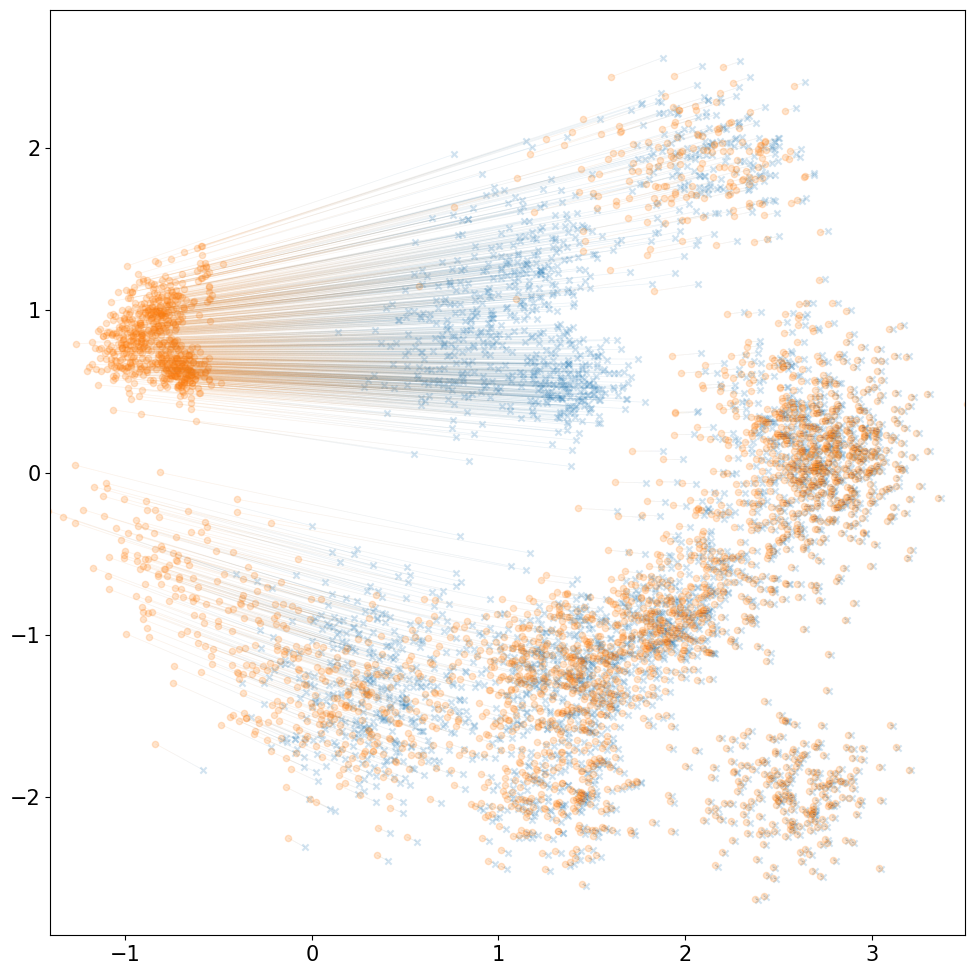

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, Normalize

# assume X_hist is shape (T, n_agents, 2)
X = np.array(X_hist)
n_agents = X.shape[1]

# build a simple two‐color colormap
cmap = LinearSegmentedColormap.from_list(
    'blue_orange', ['tab:blue', 'tab:orange']
)
norm = Normalize(0.0, 1.0)

fig, ax = plt.subplots(figsize=(10, 10))

for agent_idx in range(n_agents):
    # endpoints
    x0, y0 = X[0, agent_idx, 0], X[0, agent_idx, 1]
    x1, y1 = X[-1, agent_idx, 0], X[-1, agent_idx, 1]

    # sample along the straight line
    n_pts = 100
    t = np.linspace(0, 1, n_pts)
    xs = x0 + t * (x1 - x0)
    ys = y0 + t * (y1 - y0)

    # build segments for LineCollection
    points = np.stack([xs, ys], axis=1).reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(
        segments,
        cmap=cmap,
        norm=norm,
        linewidth=.5,
        alpha=0.1,
    )
    # color each small segment by its relative t-value
    lc.set_array(t[:-1])
    ax.add_collection(lc)

# scatter start/end
ax.scatter(
    X[0, :, 0], X[0, :, 1],
    alpha=0.2, label='Start',marker='x',
    color='tab:blue', s=20
)
ax.scatter(
    X[-1, :, 0], X[-1, :, 1],
    alpha=0.2, label='End',
    color='tab:orange', s=20,marker='o'
)

# your vertical reference line
# ax.plot([-1, -1], [-3, 3], c='r', alpha=0.3, linewidth=5)

ax.set_xlim(-1.4, 3.5)
ax.set_ylim(-2.85, 2.85)
# ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig("shift-syn.png",dpi=600)
plt.savefig("shift-syn.pdf")

plt.show()


## Network Topology

Loaded existing results for 48 sigma values.
Skipping sigma=0.1: already tested.
Skipping sigma=0.2: already tested.
Skipping sigma=0.25: already tested.
Skipping sigma=0.3: already tested.
Skipping sigma=0.35: already tested.
Skipping sigma=0.4: already tested.
Skipping sigma=0.45: already tested.
Skipping sigma=0.5: already tested.
Skipping sigma=0.55: already tested.
Skipping sigma=0.6: already tested.
Skipping sigma=0.65: already tested.
Skipping sigma=0.7: already tested.
Skipping sigma=0.75: already tested.
Skipping sigma=0.8: already tested.
Skipping sigma=0.85: already tested.
Skipping sigma=0.9: already tested.
Skipping sigma=1: already tested.
Skipping sigma=1.1: already tested.
Skipping sigma=1.2: already tested.
Skipping sigma=1.3: already tested.
Skipping sigma=1.4: already tested.
Skipping sigma=1.5: already tested.
Skipping sigma=1.7: already tested.
Skipping sigma=1.8: already tested.
Skipping sigma=2: already tested.
Skipping sigma=2.1: already tested.
Skipping sigma=2

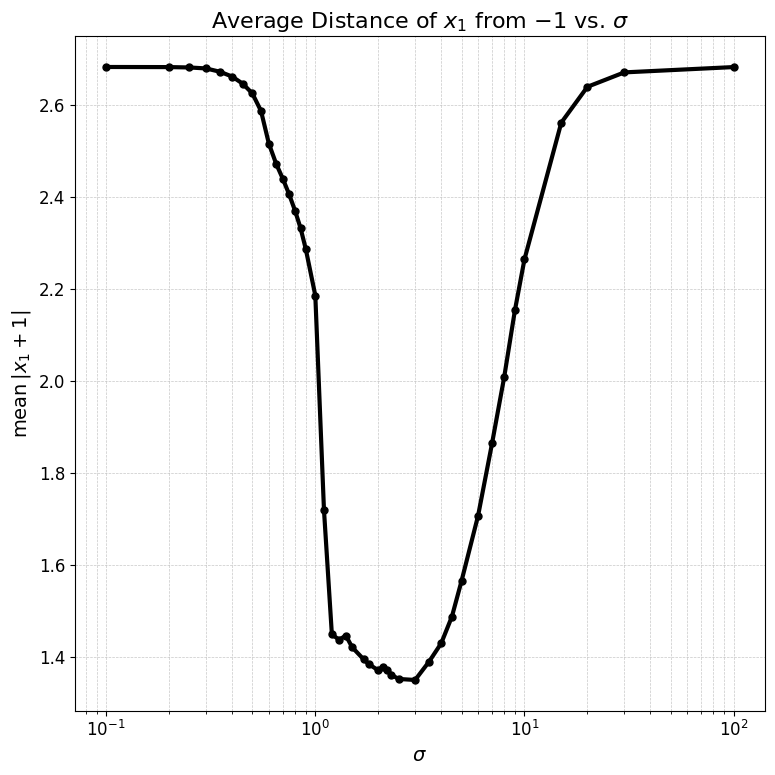

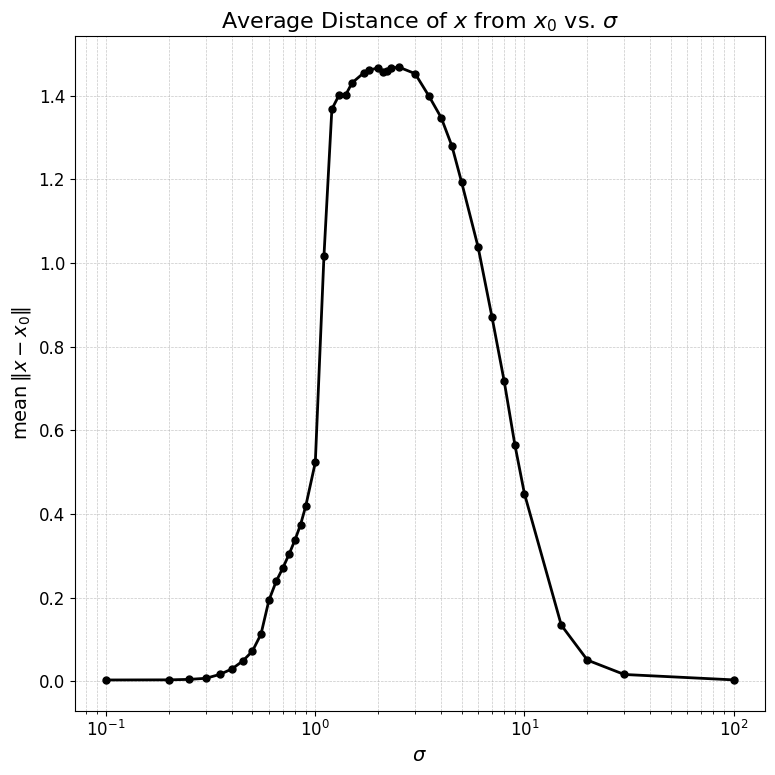

In [ ]:
import os
import numpy as np
import pickle

# Generate synthetic data
rng = np.random.default_rng(0)
K0, N_per, d = 15, 200, 2
N = K0 * N_per
xs = np.empty((N, d))
for k in range(K0):
    mean = np.array([
        rng.uniform(0, 3),  # positive x‑coordinate for centre
        rng.uniform(-2, 2),
    ])
    A = np.eye(d)
    cov = (A @ A.T) * rng.uniform(0.02, .1)
    xs[k * N_per : (k + 1) * N_per] = rng.multivariate_normal(mean, cov, N_per)

# Define sigma values to test
sigma_values = [0.1, 0.2, 0.25, 0.3, 0.35 ,0.4, 0.45, 0.5, 0.55,0.6,0.65, 0.7, 0.75, 0.8, 0.85,
                0.9, 1,1.1, 1.2,1.3,1.4, 1.5,1.7,1.8, 2, 2.1,2.2,2.3,2.5, 3,3.5, 4,4.5, 5, 6, 7, 8, 9, 10,
                15, 20, 30, 100,200,300,400,500,1000]

# Load existing results if available
results = {}
filepath = 'mpc_results_by_sigma.pkl'
if os.path.exists(filepath):
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
        # Use previously saved results
        results = data.get('results', {})
        print(f"Loaded existing results for {len(results)} sigma values.")
else:
    print("No existing results file found. Starting fresh.")

# Loop over sigma values and collect results for missing ones
for sigma in sigma_values:
    key = round(sigma, 2)
    if key in results:
        print(f"Skipping sigma={sigma}: already tested.")
        continue

    print(f"Running MPC for sigma={sigma}...")
    X_hist, uL, uF = run_clustered_mpc(
        xs,
        T_total=100,
        H=60,
        h_step=10,
        eta=0.5,
        alpha=0.3,
        sigma=sigma,
        lam=0.7,
        tom_L=9,
        tom_F=10,
        num_ilqr_iters=1,
    )
    results[key] = {'X_hist': X_hist, 'uL': uL, 'uF': uF}

# Save all results back to the pickle file
with open(filepath, 'wb') as f:
    pickle.dump({'sigma_values': sigma_values, 'results': results}, f)

print(f"Saved results for {len(results)} sigma values to '{filepath}'.")


import pickle
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})
# Load the results
with open('mpc_results_by_sigma.pkl', 'rb') as f:
    data = pickle.load(f)

sigma_values = data['sigma_values'][:-5]
results = data['results']

# Compute average distance of first dimension from -1 for each sigma
avg_distances = []
for sigma in sigma_values:
    X_hist = results[round(sigma, 2)]['X_hist']
    dist = np.abs(X_hist[:, :, 0] + 1)
    avg_distances.append(dist.mean())

# Create a professional-looking plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.semilogx(
    sigma_values,
    avg_distances,
    marker='.',
    linestyle='-',
    linewidth=3,
    markersize=10,
    color='black'

)

# Labels and title with LaTeX formatting
ax.set_xlabel(r'$\sigma$', fontsize=14)
ax.set_ylabel(r'$\mathrm{mean}\,| x_1 + 1|$', fontsize=14)
ax.set_title('Average Distance of $x_1$ from $-1$ vs. $\\sigma$', fontsize=16)

# Grid and spines adjustments
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# Tick parameters for readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Tight layout
plt.tight_layout()
plt.savefig("sigma_vs_distance_syn_adv.svg")
plt.show()
import pickle
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})
# Load the results
with open('mpc_results_by_sigma.pkl', 'rb') as f:
    data = pickle.load(f)

sigma_values = data['sigma_values'][:-5]
results = data['results']

# Compute average distance of first dimension from -1 for each sigma
avg_distances = []
for sigma in sigma_values:
    X_hist = results[round(sigma, 2)]['X_hist']
    dist = np.linalg.norm(X_hist-xs,axis=2)
    avg_distances.append(dist.mean())

# Create a professional-looking plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.semilogx(
    sigma_values,
    avg_distances,
    marker='.',
    linestyle='-',
    linewidth=2,
    markersize=10,
    color='black'
)

# Labels and title with LaTeX formatting
ax.set_xlabel(r'$\sigma$', fontsize=14)
ax.set_ylabel(r'$\mathrm{mean}\,\| x -x_0 \|$', fontsize=14)
ax.set_title('Average Distance of $x$ from $x_0$ vs. $\\sigma$', fontsize=16)

# Grid and spines adjustments
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# Tick parameters for readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Tight layout
plt.tight_layout()
plt.savefig("sigma_vs_distance_syn_def.svg")
plt.show()


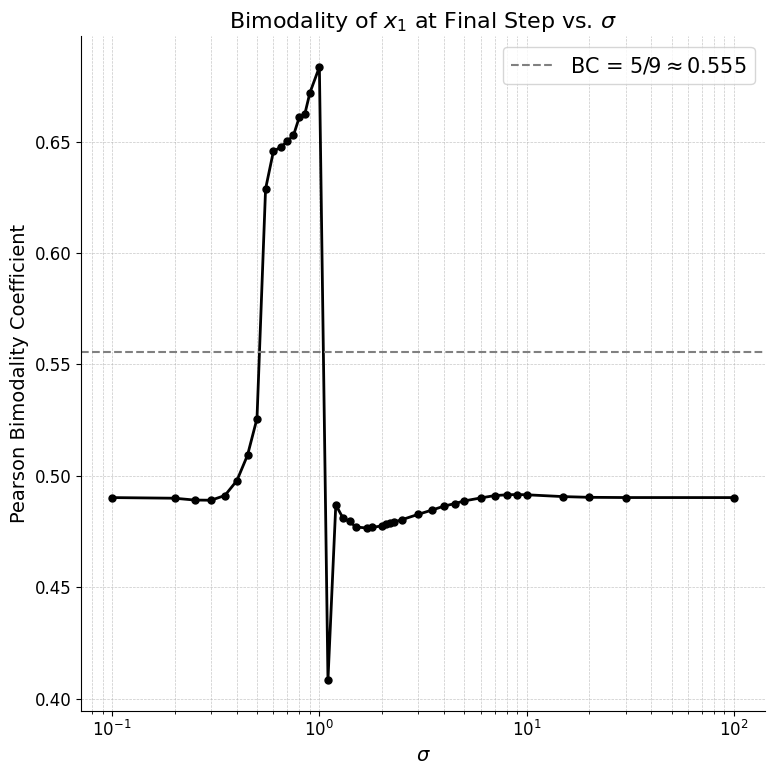

In [ ]:
from scipy.stats import skew, kurtosis

# ------------------------------------------------------------------
# Compute Pearson's Bimodality Coefficient of x₁ at the final step
# ------------------------------------------------------------------
bim_coeffs = []
for sigma in sigma_values:
    X_hist = results[round(sigma, 2)]['X_hist']
    final_x1 = X_hist[-1, :, 0]             # x₁ values at final time
    g = skew(final_x1, bias=False)         # sample skewness
    k = kurtosis(final_x1, fisher=False, bias=False)  # Pearson kurtosis
    bc = (g**2 + 1) / k
    bim_coeffs.append(bc)

# ------------------------------------------------------------------
# Plot BC vs sigma
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))
ax.semilogx(
    sigma_values,
    bim_coeffs,
    marker='.',
    linestyle='-',
    linewidth=2,
    markersize=10,
    color='black'
)

# Threshold line at BC = 5/9 for reference
ax.axhline(5/9, color='gray', linestyle='--', label=r'BC = $5/9\approx0.555$')

# Labels and title
ax.set_xlabel(r'$\sigma$', fontsize=14)
ax.set_ylabel('Pearson Bimodality Coefficient', fontsize=14)
ax.set_title('Bimodality of $x_1$ at Final Step vs. $\\sigma$', fontsize=16)

# Styling
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()

plt.tight_layout()
plt.savefig("sigma_vs_bimodality_syn.svg")
plt.show()


# Facebook

## data loader

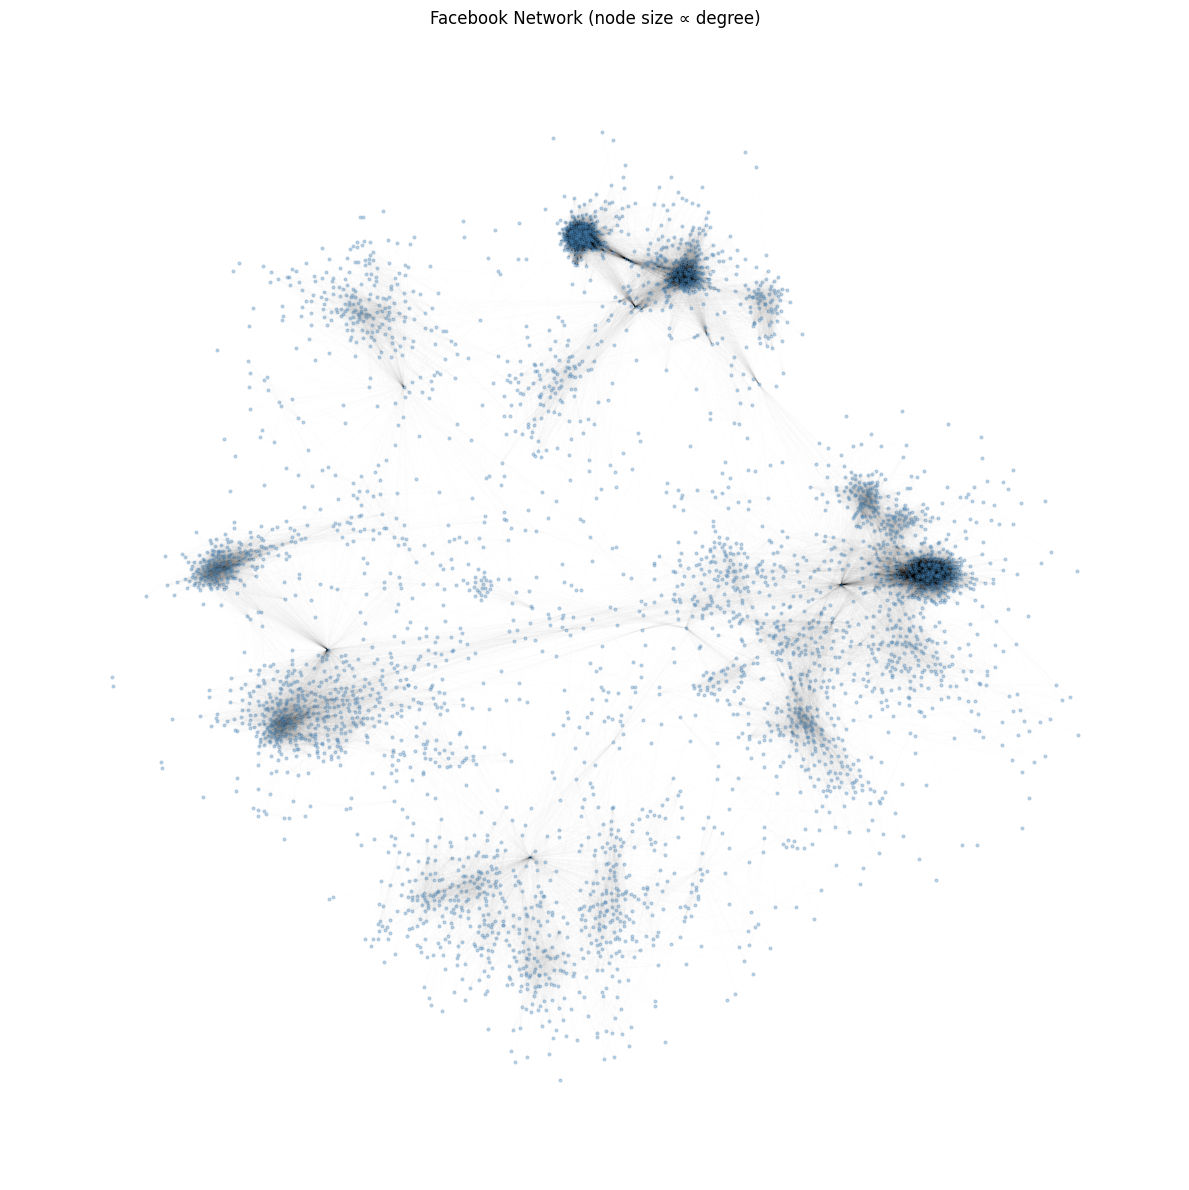

In [ ]:
# Facebook Network
import networkx as nx
import matplotlib.pyplot as plt

# 1. Load the edge list
G = nx.read_edgelist('Ego-Facebook.txt', nodetype=int)

# 2. (Optional) Extract the largest connected component
if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    print(f"  → Plotting largest component with {G.number_of_nodes()} nodes")

# 3. Compute a faster spring layout
#    - k controls the optimal distance between nodes (smaller = tighter)
#    - iterations trades off accuracy vs. speed
pos = nx.spring_layout(G, seed=42, k=0.1, iterations=50)

# 4. Draw the graph
degree_dict = dict(G.degree())
node_sizes = [degree_dict[node] for node in G.nodes()]
plt.figure(figsize=(12, 12), dpi=100)
nx.draw_networkx_nodes(
    G, pos,
    node_size=4,
    node_color='steelblue',
    alpha=0.3
)
nx.draw_networkx_edges(
    G, pos,
    width=1,
    alpha=0.002
)

plt.title("Facebook Network (node size ∝ degree)")
plt.axis('off')
plt.tight_layout()
plt.show()

# clusters: 53
# clusters: 44
# clusters: 44
# clusters: 40
# clusters: 40
# clusters: 39
# clusters: 39
# clusters: 39
# clusters: 38
# clusters: 39


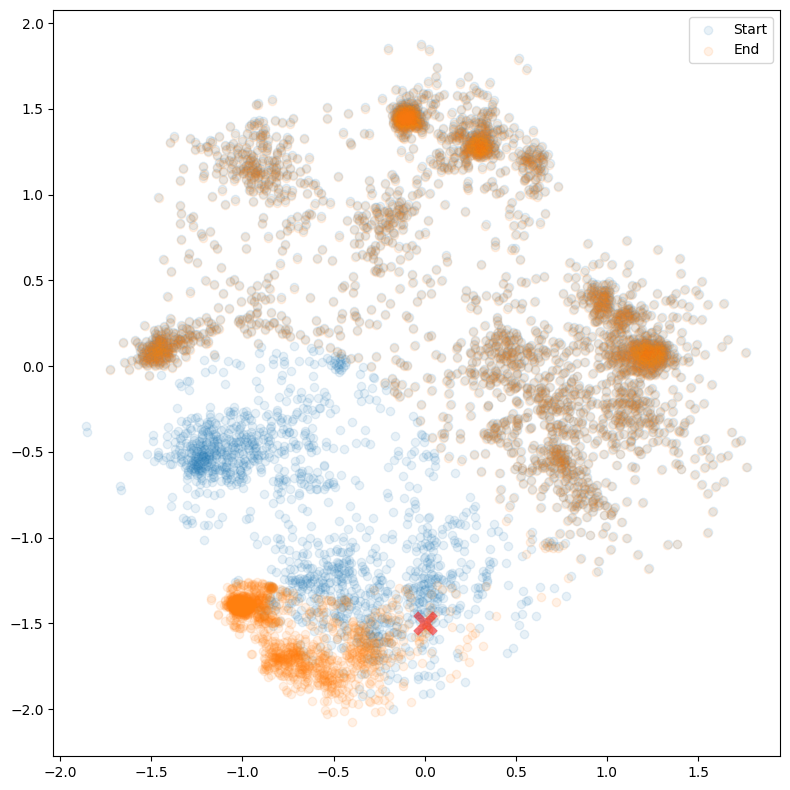

In [ ]:
# =====================================================================
#  Results
# =====================================================================


# Facebook net
nodes = list(G.nodes())
xs = np.vstack([2*pos[n] for n in nodes])
T_total=100
X_hist, uL, uF = run_clustered_mpc(
    xs,
    T_total=T_total,
    H=60,
    h_step=10,
    eta=1,
    alpha=.5,
    sigma=0.32,
    lam=0.7,
    tom_L=9,
    tom_F=10,
    num_ilqr_iters=1)

import numpy as np
import matplotlib.pyplot as plt
X=np.array(X_hist)
plt.figure(figsize=(8, 8))
plt.scatter(X[0, :, 0],X[0,:,1],alpha=0.1,label='Start')
plt.scatter(X[-1, :, 0],X[-1,:,1],alpha=0.1,label='End')
# plt.plot([-1,-1],[-1,1],c='r',alpha=0.3,linewidth=5)
plt.scatter([0],[-1.5],c='r',alpha=0.5,linewidth=5,s=200,marker='x')

plt.legend()
plt.tight_layout()
plt.show()

## Final Plots

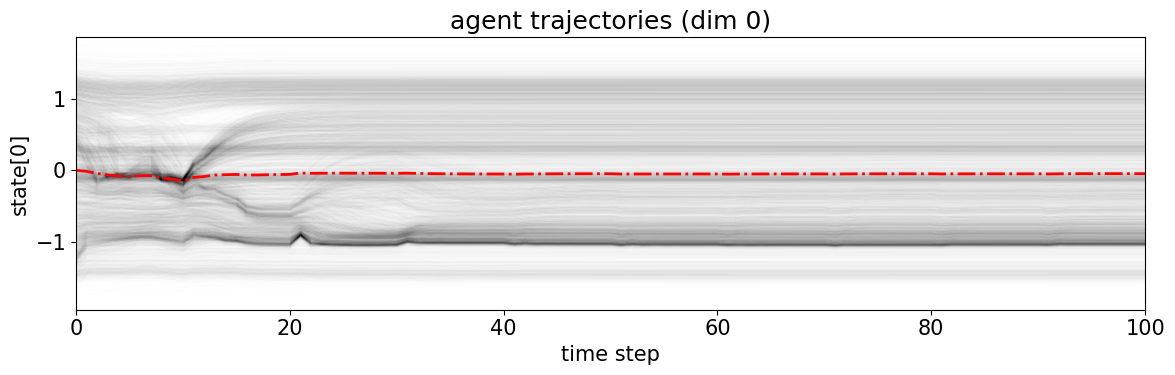

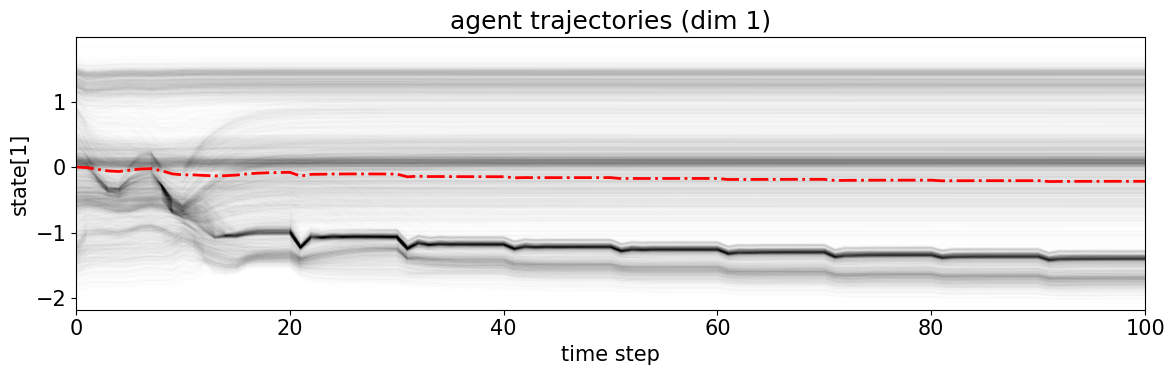

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import jax.numpy as jnp

plt.rcParams.update({'font.size': 15})

time_steps = jnp.arange(T_total + 1)
d_agent=X.shape[2]
n_agents=X.shape[1]
# initial “second” state (dim=1) for each agent
init_vals = X_hist[0, :, 1]  # shape (n_agents,)

# set up colormap and normalization
cmap = plt.cm.RdYlGn_r
norm = mpl.colors.Normalize(vmin=init_vals.min(), vmax=init_vals.max())

for dim_idx in range(d_agent):
    # create fig/ax so we can pass ax to colorbar
    fig, ax = plt.subplots(figsize=(12, 4))

    # plot each agent trajectory
    for agent_idx in range(n_agents):
        color = cmap(norm(init_vals[agent_idx]))
        ax.plot(time_steps,
                X_hist[:, agent_idx, dim_idx],
                alpha=0.005,
                color="black")

    # plot the mean trajectory
    ax.plot(time_steps,
            jnp.mean(X_hist[:, :, dim_idx], axis=1),
            color="red",
            linestyle="-.",
            linewidth=2)

    ax.set_xlabel("time step")
    ax.set_ylabel(f"state[{dim_idx}]")
    ax.set_title(f"agent trajectories (dim {dim_idx})")
    ax.grid(False)
    ax.set_xlim(0, T_total)
    ax.set_ylim( X_hist[:, :, dim_idx].min() - 0.1, X_hist[:, :, dim_idx].max() + 0.1)

    # make a ScalarMappable for the colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(init_vals)  # needed even if we're not re-drawing data

    # attach the colorbar to our axis
    # cbar = fig.colorbar(sm, ax=ax)
    # cbar.set_label("initial state[1]")
    plt.savefig(f"real_dim_{dim_idx}.pdf")
    plt.tight_layout()
    plt.show()


## Shifts

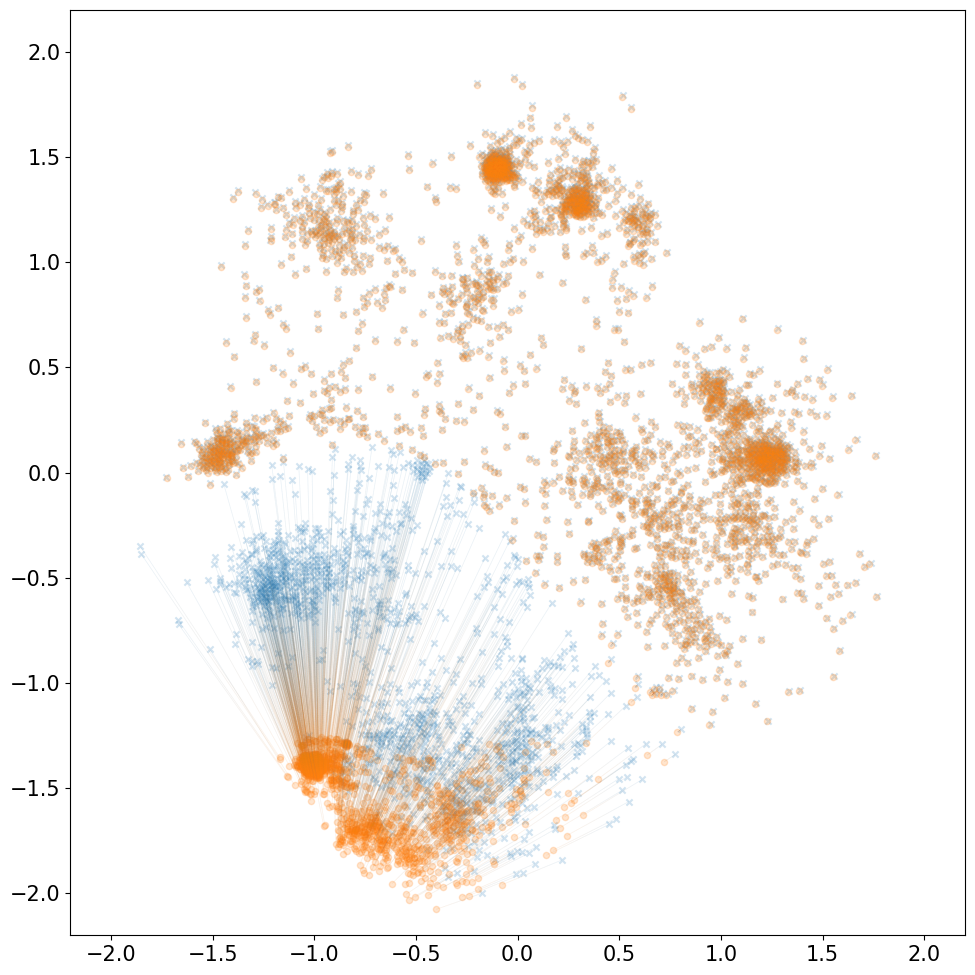

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, Normalize

# assume X_hist is shape (T, n_agents, 2)
X = np.array(X_hist)
n_agents = X.shape[1]

# build a simple two‐color colormap
cmap = LinearSegmentedColormap.from_list(
    'blue_orange', ['tab:blue', 'tab:orange']
)
norm = Normalize(0.0, 1.0)

fig, ax = plt.subplots(figsize=(10, 10))

for agent_idx in range(n_agents):
    # endpoints
    x0, y0 = X[0, agent_idx, 0], X[0, agent_idx, 1]
    x1, y1 = X[-1, agent_idx, 0], X[-1, agent_idx, 1]

    # sample along the straight line
    n_pts = 100
    t = np.linspace(0, 1, n_pts)
    xs = x0 + t * (x1 - x0)
    ys = y0 + t * (y1 - y0)

    # build segments for LineCollection
    points = np.stack([xs, ys], axis=1).reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(
        segments,
        cmap=cmap,
        norm=norm,
        linewidth=.5,
        alpha=0.1,
    )
    # color each small segment by its relative t-value
    lc.set_array(t[:-1])
    ax.add_collection(lc)

# scatter start/end
ax.scatter(
    X[0, :, 0], X[0, :, 1],
    alpha=0.2, label='Start',marker='x',
    color='tab:blue', s=20
)
ax.scatter(
    X[-1, :, 0], X[-1, :, 1],
    alpha=0.2, label='End',
    color='tab:orange', s=20,marker='o'
)

# your vertical reference line
# ax.plot([-1, -1], [-2, 2], c='r', alpha=0.3, linewidth=5)
# plt.scatter([0],[-1.5],c='r',alpha=0.5,linewidth=5,s=200,marker='x')

ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-2.2, 2.2)
# ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig("shift-real.png",dpi=600)
plt.savefig("shift-real.pdf")
plt.show()


## Network Topology

No existing results file found. Starting fresh.
Running MPC for sigma=0.1...
# clusters: 53
# clusters: 51
# clusters: 48
# clusters: 49
# clusters: 51
# clusters: 50
# clusters: 46
# clusters: 51
# clusters: 47
# clusters: 48
Running MPC for sigma=0.2...
# clusters: 53
# clusters: 49
# clusters: 50
# clusters: 46
# clusters: 46
# clusters: 47
# clusters: 51
# clusters: 46
# clusters: 48
# clusters: 47
Running MPC for sigma=0.25...
# clusters: 53
# clusters: 47
# clusters: 44
# clusters: 46
# clusters: 43
# clusters: 44
# clusters: 43
# clusters: 42
# clusters: 47
# clusters: 42
Running MPC for sigma=0.3...
# clusters: 53
# clusters: 40
# clusters: 39
# clusters: 43
# clusters: 40
# clusters: 41
# clusters: 42
# clusters: 40
# clusters: 41
# clusters: 40
Running MPC for sigma=0.35...
# clusters: 53
# clusters: 36
# clusters: 40
# clusters: 40
# clusters: 37
# clusters: 38
# clusters: 38
# clusters: 39
# clusters: 37
# clusters: 37
Running MPC for sigma=0.4...
# clusters: 53
# clusters:

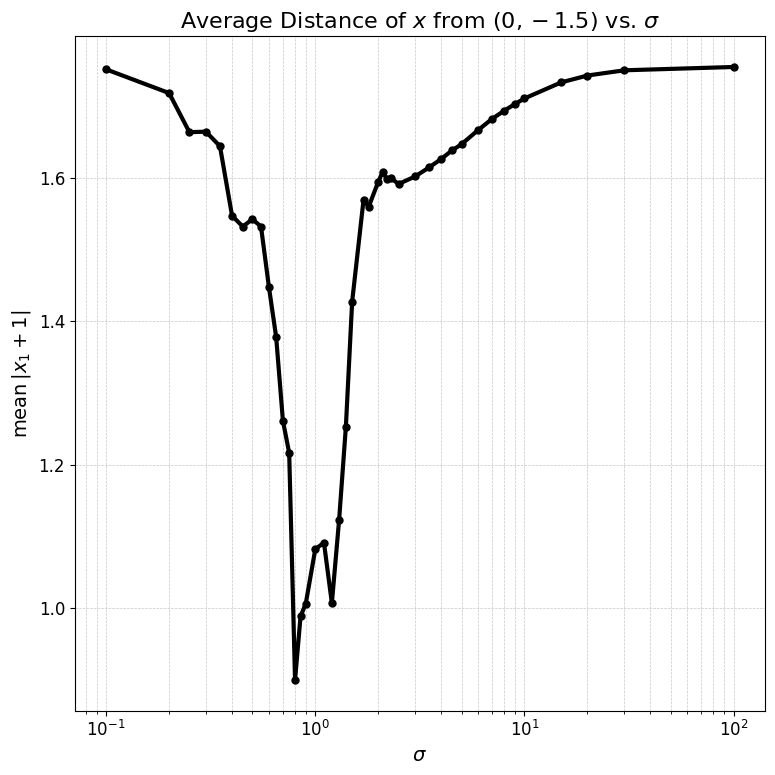

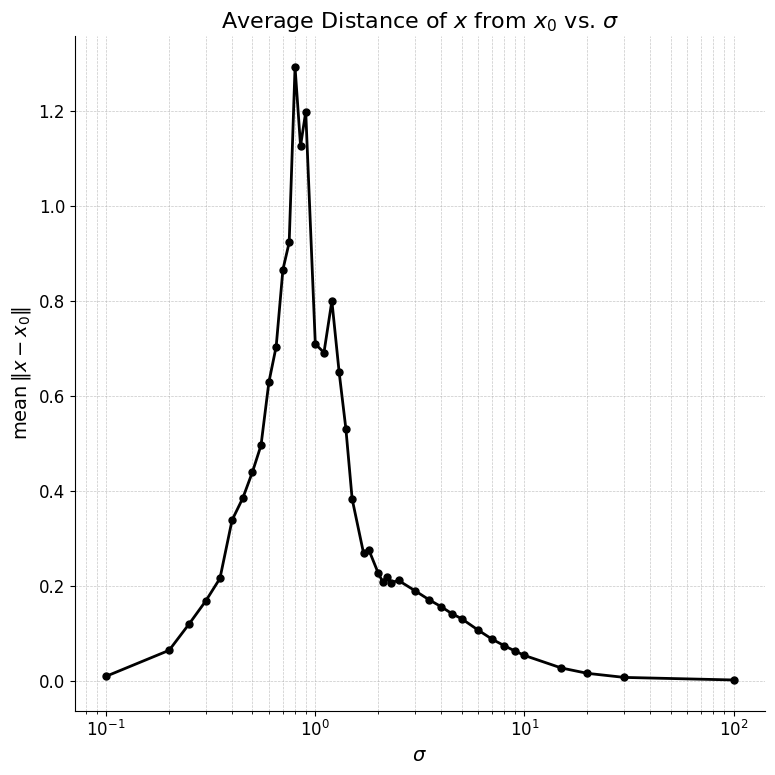

In [ ]:
import os
import numpy as np
import pickle

nodes = list(G.nodes())
xs = np.vstack([2*pos[n] for n in nodes])
T_total=100
# Define sigma values to test
sigma_values = [0.1, 0.2, 0.25, 0.3, 0.35 ,0.4, 0.45, 0.5, 0.55,0.6,0.65, 0.7, 0.75, 0.8, 0.85,
                0.9, 1,1.1, 1.2,1.3,1.4, 1.5,1.7,1.8, 2, 2.1,2.2,2.3,2.5, 3,3.5, 4,4.5, 5, 6, 7, 8, 9, 10,
                15, 20, 30, 100,200,300,400,500,1000]

# Load existing results if available
results = {}
filepath = 'mpc_results_by_sigma_facebook.pkl'
if os.path.exists(filepath):
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
        # Use previously saved results
        results = data.get('results', {})
        print(f"Loaded existing results for {len(results)} sigma values.")
else:
    print("No existing results file found. Starting fresh.")

# Loop over sigma values and collect results for missing ones
for sigma in sigma_values:
    key = round(sigma, 2)
    if key in results:
        print(f"Skipping sigma={sigma}: already tested.")
        continue

    print(f"Running MPC for sigma={sigma}...")
    X_hist, uL, uF = run_clustered_mpc(
        xs,
        T_total=100,
        H=60,
        h_step=10,
        eta=1,
        alpha=0.5,
        sigma=sigma,
        lam=0.7,
        tom_L=9,
        tom_F=10,
        num_ilqr_iters=1,
    )
    results[key] = {'X_hist': X_hist, 'uL': uL, 'uF': uF}

# Save all results back to the pickle file
with open(filepath, 'wb') as f:
    pickle.dump({'sigma_values': sigma_values, 'results': results}, f)

print(f"Saved results for {len(results)} sigma values to '{filepath}'.")


import pickle
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})
# Load the results
with open('mpc_results_by_sigma_facebook.pkl', 'rb') as f:
    data = pickle.load(f)

sigma_values = data['sigma_values'][:-5]
results = data['results']

# Compute average distance of from (0,-1.5)
avg_distances = []
for sigma in sigma_values:
    X_hist = results[round(sigma, 2)]['X_hist']
    dist = np.linalg.norm(X_hist - np.array([0, -1.5]),axis=2)
    avg_distances.append(dist.mean())

# Create a professional-looking plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.semilogx(
    sigma_values,
    avg_distances,
    marker='.',
    linestyle='-',
    linewidth=3,
    markersize=10,
    color='black'

)

# Labels and title with LaTeX formatting
ax.set_xlabel(r'$\sigma$', fontsize=14)
ax.set_ylabel(r'$\mathrm{mean}\,| x_1 + 1|$', fontsize=14)
ax.set_title('Average Distance of $x$ from $(0,-1.5)$ vs. $\\sigma$', fontsize=16)

# Grid and spines adjustments
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# Tick parameters for readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Tight layout
plt.tight_layout()
plt.savefig("sigma_vs_distance_facebook_adv.svg")
plt.show()


# Compute average distance of first dimension from -1 for each sigma
avg_distances = []
for sigma in sigma_values:
    X_hist = results[round(sigma, 2)]['X_hist']
    dist = np.linalg.norm(X_hist-xs,axis=2)
    avg_distances.append(dist.mean())

# Create a professional-looking plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.semilogx(
    sigma_values,
    avg_distances,
    marker='.',
    linestyle='-',
    linewidth=2,
    markersize=10,
    color='black'
)

# Labels and title with LaTeX formatting
ax.set_xlabel(r'$\sigma$', fontsize=14)
ax.set_ylabel(r'$\mathrm{mean}\,\| x -x_0 \|$', fontsize=14)
ax.set_title('Average Distance of $x$ from $x_0$ vs. $\\sigma$', fontsize=16)

# Grid and spines adjustments
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tick parameters for readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Tight layout
plt.tight_layout()
plt.savefig("sigma_vs_distance_facebook_def.svg")
plt.show()


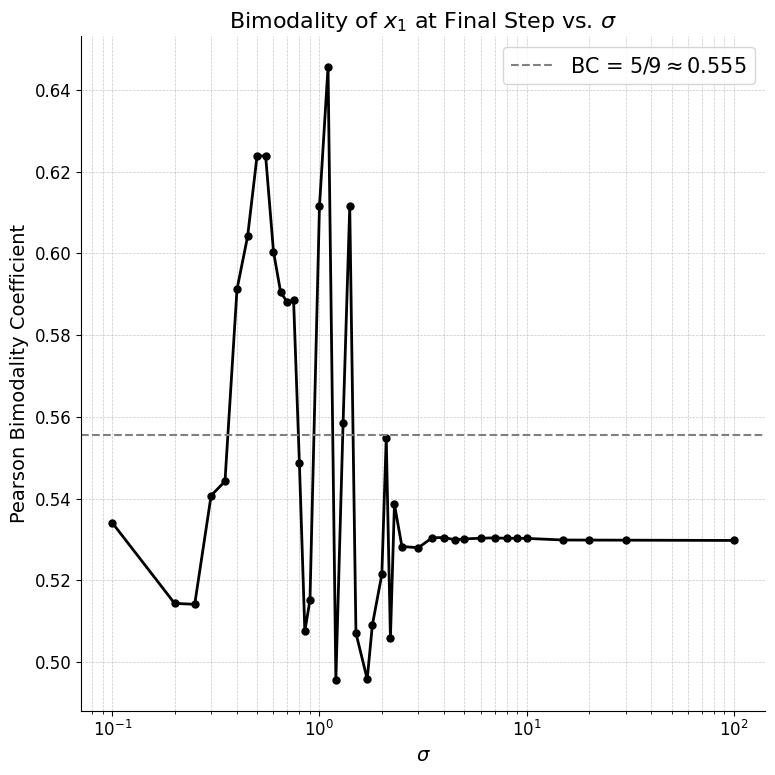

In [ ]:
from scipy.stats import skew, kurtosis

# ------------------------------------------------------------------
# Compute Pearson's Bimodality Coefficient of x₁ at the final step
# ------------------------------------------------------------------
bim_coeffs = []
for sigma in sigma_values:
    X_hist = results[round(sigma, 2)]['X_hist']
    final_x1 = X_hist[-1, :, 0]             # x₁ values at final time
    g = skew(final_x1, bias=False)         # sample skewness
    k = kurtosis(final_x1, fisher=False, bias=False)  # Pearson kurtosis
    bc = (g**2 + 1) / k
    bim_coeffs.append(bc)

# ------------------------------------------------------------------
# Plot BC vs sigma
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))
ax.semilogx(
    sigma_values,
    bim_coeffs,
    marker='.',
    linestyle='-',
    linewidth=2,
    markersize=10,
    color='black'
)

# Threshold line at BC = 5/9 for reference
ax.axhline(5/9, color='gray', linestyle='--', label=r'BC = $5/9\approx0.555$')

# Labels and title
ax.set_xlabel(r'$\sigma$', fontsize=14)
ax.set_ylabel('Pearson Bimodality Coefficient', fontsize=14)
ax.set_title('Bimodality of $x_1$ at Final Step vs. $\\sigma$', fontsize=16)

# Styling
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()

plt.tight_layout()
plt.savefig("sigma_vs_bimodality_facebook.svg")
plt.show()


# Schematics

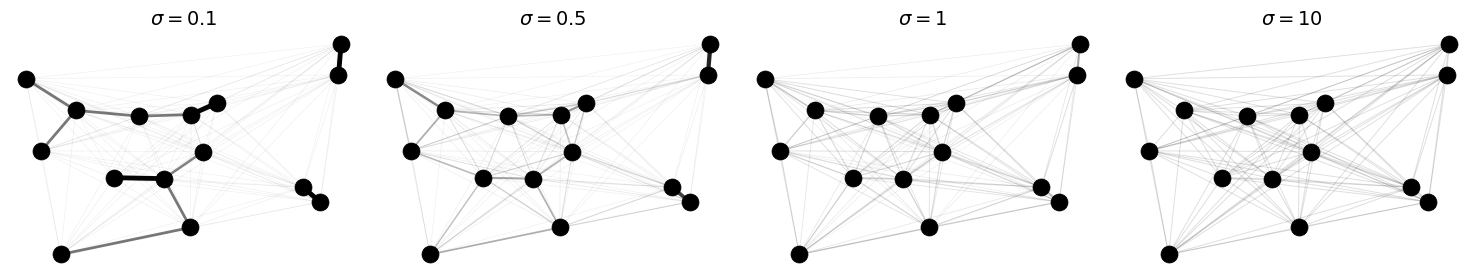

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Parameters
rng = np.random.default_rng()
K0 = 15  # number of nodes
sigma_values = [0.1,0.5, 1, 10]  # small, medium, and large sigma for illustration

# Generate synthetic node positions
positions = {i: rng.uniform([0, -1], [3, 2]) for i in range(K0)}

# Plot for each sigma
fig, axes = plt.subplots(1, len(sigma_values), figsize=(15, 3))

for ax, sigma in zip(axes, sigma_values):
    # Compute raw Gaussian weights (no self-loops)
    raw = np.zeros((K0, K0))
    for i in range(K0):
        for j in range(K0):
            if i != j:
                dist = np.linalg.norm(positions[i] - positions[j])
                raw[i, j] = np.exp(-dist**2 / (2 * sigma**2))
    # Row-normalize weights
    row_sums = raw.sum(axis=1, keepdims=True)
    norm = raw / row_sums

    # Build symmetric weight for undirected plotting
    w_sym = (norm + norm.T) / 2

    # Draw every edge with thickness and transparency per symmetrized norm
    min_width = .5
    scale_width = 3
    min_alpha = 0.06
    for i in range(K0):
        for j in range(i+1, K0):
            w = w_sym[i, j]
            linewidth = min_width + scale_width * w
            alpha = min_alpha + (1 - min_alpha) * w
            x0, y0 = positions[i]
            x1, y1 = positions[j]
            ax.plot([x0, x1], [y0, y1],
                    linewidth=linewidth,
                    alpha=alpha,
                    color='black',
                    zorder=1  # edges behind
                   )

    # Draw nodes in front
    xs = np.array([positions[i] for i in positions])
    ax.scatter(xs[:, 0], xs[:, 1],
               s=150,             # bigger node size
               color='black',       # red color
               zorder=2,          # on top of edges
               edgecolors='black',
               linewidth=0.5
              )
    ax.set_title(f"$\\sigma = {sigma}$", fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.savefig("schematic.svg")
plt.show()
